# Analyzing the relationship between literary topics and literary prestige accross time


We will try to see if:
- The distribution of topics changes between prestigious and non-prestigious writers
- How does a prestigious authors' engagement with certain topics changes before and after their literary consecration
- Does the relationship between topics and prestige change over time ?


## 1. Data preparation

### 1.1. Load raw data for author selection

In [1]:
import pandas as pd
import pickle
with open('data/preprocessed_dump.pkl', 'rb') as fp:
    processed_content = pickle.load(fp)
    
preproc = {}
for folder in processed_content.keys():
    for i, entry in enumerate(processed_content[folder]):
        preproc[folder + '-' + str(i)] = '. '.join(entry['filtered_content'])
        
original = {}
for folder in processed_content.keys():
    for i, entry in enumerate(processed_content[folder]):
        original[folder + '-' + str(i)] = entry['content']



In [2]:
ori_df = pd.DataFrame.from_dict(original, orient="index")
ori_df['year']=list(ori_df.index.str[:4])
ori_df['year']=ori_df['year'].astype(int)
ori_df['no_space'] = ori_df[0].apply(lambda x: x.replace(' ', ''))

We create a simple heuristic to determine if a text was written by a certain author by checking if his name appears at the beginning of the novel (none of the names are common enough that they would be used to name a character)

In [3]:
def is_author_present(author, text):
    if author in text and text.find(author) < 1000:
        return True
    else:
        return False

In [4]:
ori_df[ori_df['no_space'].apply(lambda x: is_author_present('리신현', x))]

,0,year,no_space
1977-09-0,단편소설 각이 깊었다. 모질게 눌러껐다. 《어서 오시오.》 열 ...,1977,단편소설각이깊었다.모질게눌러껐다.《어서오시오.》열풍었다.니…)채만식직장장을찾아가는소...
1981-01-2,단편소설 빨간 수기 누구든지 포연이 스민 전선생활을 맛본 사람이 면...,1981,단편소설빨간수기누구든지포연이스민전선생활을맛본사람이면이말의참뜻을리해할수있을것이다.이를...
1981-09-0,단편소설 정다운 창문들 사택마을의 례사로운 하루저녁도 저물어가고있 었다...,1981,단편소설정다운창문들사택마을의례사로운하루저녁도저물어가고있었다.즐거운로동의하루를마치고돌...
1982-07-0,단편소설 지팽이 장지삼은 한달열흘간의 료양생활을 마치고 돌 아 온 ...,1982,단편소설지팽이장지삼은한달열흘간의료양생활을마치고돌아온얼마전까지만하여도기분이대단히좋았다...
1985-11-0,당비서의 밤길 단편소설 박상규는 매일같이 눈코뜰새 없이 들볶이는 생...,1985,당비서의밤길단편소설박상규는매일같이눈코뜰새없이들볶이는생활에쩌들고습관된지라오늘도현장에서...


We now create a list of prestigious authors, along with the date of their 'canonization' (their admission into the 4.15 LPU).
We'll print the number of short stories we have for each writer.

In [5]:
author_by_year = {'백남룡': 1985,
                 '리신현': 1998,
                 '김삼복': 1998,
                 '윤경찬': 2013,
                 '안동춘': 1990,
                 '탁숙본': 2013,
                 '백보흠': 1989,
                 '정기종': 1992,
                 '김수경': 1989,
                 '림봉철': 2015,
                 '리동구': 2002,
                 '박태수': 2000,
                 '전흥식': 2012,
                 '최영조': 2011,
                 '윤정길': 2014,
                 '진재환': 1984,
                 '조권일': 2018,
                 '허춘식': 1997,
                 '권정웅': 1969,
                 '김병훈': 1969,
                 '남대현': 1992,
                 '리종렬': 1981,
                 '박룡운': 2001,
                 '석윤기': 1969,
                 '최학수': 1976,
                 '현승걸': 1976,
                 }

In [6]:
for author, year in author_by_year.items():
    print(f'{author}\t{year}\t{sum(ori_df["no_space"].apply(lambda x: is_author_present(author, x)))}')

백남룡	1985	10
리신현	1998	5
김삼복	1998	4
윤경찬	2013	8
안동춘	1990	11
탁숙본	2013	10
백보흠	1989	8
정기종	1992	7
김수경	1989	1
림봉철	2015	7
리동구	2002	2
박태수	2000	3
전흥식	2012	5
최영조	2011	2
윤정길	2014	1
진재환	1984	2
조권일	2018	1
허춘식	1997	1
권정웅	1969	4
김병훈	1969	4
남대현	1992	4
리종렬	1981	2
박룡운	2001	0
석윤기	1969	0
최학수	1976	3
현승걸	1976	3


### 1.2. Rerun topic modelling

In [7]:
import pickle
with open('data/preprocessed_dump.pkl', 'rb') as fp:
    processed_content = pickle.load(fp)

In [8]:
import re

df = pd.DataFrame.from_dict(preproc, orient="index")

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.75, min_df=10, max_features=3000, stop_words=['로이', '하', '는', '은', '를', '가', '이', '을', '하시', '머니', '리당', ''])
X = vectorizer.fit_transform([re.sub('\.*께', '', _) for _ in df[0].to_list()])
nmf = NMF(n_components=7, init = 'nndsvd').fit(X)
display_topics(nmf, vectorizer.get_feature_names(), 50)


Topic 0:
아버지, 선생님, 선생, 처녀, 남편, 학생, 조선, 바다, 청년, 일본, 조국, 학교, 연구, 교원, 대학, 교수, 안해, 나무, 할아버지, 편지, 고향, 아이들, 민족, 아들, 할머니, 그림, 의사, 소년, 왜놈, 인간, 노래, 병원, 공부, 작품, 마을, 아이, 세상, 환자, 연구사, 오빠, 딸애, 언니, 교장, 시절, 옥이, 아름답, 손님, 동포, 배우, 박사
Topic 1:
장군, 동지, 김정숙, 말씀, 김정일, 김일성, 인민, 어머님, 사령관, 경애, 최고, 일군, 김정은, 드리, 혁명, 해방, 공장, 왜놈, 위대, 부대, 모시, 건설, 삼은, 주시, 작전, 승용차, 조선, 전선, 장령, 평양, 발전소, 전쟁, 계시, 사령부, 민족, 아들, 병사, 전사, 문건, 군인, 사진, 음성, 보시, 조국, 웃으시였다, 싸우, 세상, 우러르, 가시, 김책
Topic 2:
어머니, 아버지, 아들, 엄마, 남편, 할머니, 고향, 마을, 아저씨, 자식, 아이, 어머님, 편지, 동생, 오빠, 옥이, 할아버지, 철이, 애가, 학교, 아이들, 위원장, 남이, 부모, 세상, 시어머니, 조국, 부엌, 삼은, 집안, 애기, 마당, 병사, 키우, 안해, 행복, 며느리, 옥녀, 군대, 나무, 아주머니, 에미, 시절, 대문, 염소, 전쟁, 학원, 데리, 사진, 가정
Topic 3:
수령, 말씀, 김정일, 어버이, 동지, 인민, 위대, 지도자, 일군, 친애, 지도자동지, 친애하는, 드리, 혁명, 위원장, 부관, 조국, 력사, 승용차, 관리, 경애, 주석, 민족, 조선, 계시, 음성, 집무실, 모시, 보시, 형상, 사업, 책임, 작품, 작가, 주시, 평양, 최현, 세계, 김일성, 강냉이, 농사, 농장, 농업, 투사, 전쟁, 인간, 학자, 서기, 현지, 백두산
Topic 4:
지배인, 공장, 직장, 기사, 생산, 기술, 동지, 설계, 당비서, 탄광, 비서, 처녀, 설비, 광산, 기중기, 청년, 건설, 도면, 현장, 일군, 책임, 사업, 기계, 자재, 기업소, 소조원, 건

In [9]:
nmf_output = nmf.transform(X)

## 2. Topic distribution for canonized authors (before and after canonization)

In [11]:
indices_stars = []
for author in author_by_year.keys():
    indices_stars += [i for i, found in enumerate(list(ori_df['no_space'].apply(lambda x: is_author_present(author, x)))) if found]

In [12]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry', 'Agriculture', 'Military']
topic_res = pd.DataFrame(np.round(nmf_output[indices_stars], 2), columns=topics)
topic_res['Leaders'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]
topic_res

,Education,Family,Industry,Agriculture,Military,Leaders,dominant_topic
0,0.00,0.03,0.16,0.10,0.00,0.00,Industry
1,0.11,0.09,0.03,0.00,0.00,0.00,Education
2,0.00,0.00,0.30,0.00,0.00,0.00,Industry
3,0.06,0.18,0.00,0.01,0.00,0.00,Family
4,0.04,0.06,0.23,0.01,0.00,0.00,Industry
...,...,...,...,...,...,...,...
103,0.01,0.00,0.00,0.00,0.00,0.26,Leaders
104,0.04,0.00,0.01,0.00,0.03,0.11,Leaders
105,0.03,0.02,0.05,0.00,0.03,0.12,Leaders
106,0.05,0.02,0.01,0.00,0.03,0.12,Leaders


In [13]:
topic_res['dominant_topic'].value_counts()

Leaders        41
Education      21
Military       19
Industry       18
Agriculture     5
Family          4
Name: dominant_topic, dtype: int64

### 2.1. Distribution by dominant topic

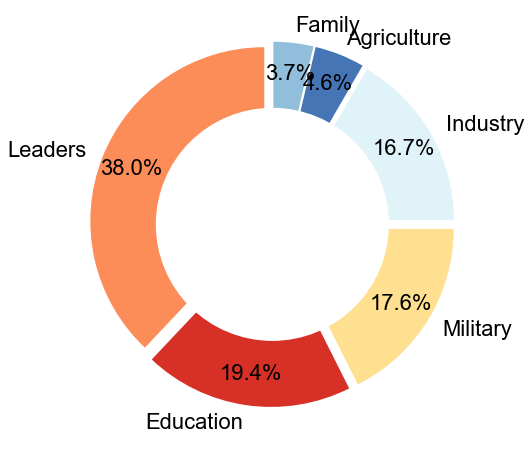

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)
topic_columns = list(topic_res.columns)
topic_columns.pop(topic_columns.index('dominant_topic'))
colors_gender = ['#fc8d59','#d73027','#fee090','#e0f3f8','#4575b4','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

### 2.2. Distribution by topic weight

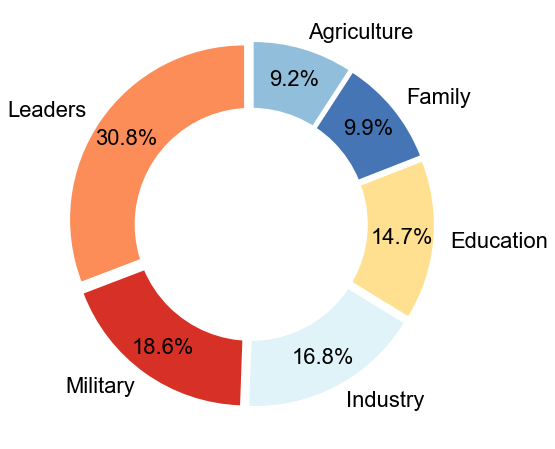

In [15]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)

colors_gender = ['#fc8d59','#d73027','#e0f3f8', '#fee090','#4575b4','#91bfdb']
ax=topic_res[topic_columns].sum().sort_values(ascending=False).plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

## 3. Topic distribution for canonized writers before canonization

We will consider the dominant topic for each short story

In [16]:
indices_before_stars = []
for author, year in author_by_year.items():
    author_present = ori_df['no_space'].apply(lambda x: is_author_present(author, x))
    before_famous = ori_df['year'] < year
    indices_before_stars += [i for i, found in enumerate(list(author_present & before_famous)) if found]

In [17]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry *', 'Agriculture', 'Military *']
topic_res = pd.DataFrame(np.round(nmf_output[indices_before_stars], 2), columns=topics)
topic_res['Leaders'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]
topic_res

,Education,Family,Industry *,Agriculture,Military *,Leaders,dominant_topic
0,0.00,0.03,0.16,0.10,0.00,0.00,Industry *
1,0.11,0.09,0.03,0.00,0.00,0.00,Education
2,0.00,0.00,0.30,0.00,0.00,0.00,Industry *
3,0.06,0.18,0.00,0.01,0.00,0.00,Family
4,0.04,0.06,0.23,0.01,0.00,0.00,Industry *
...,...,...,...,...,...,...,...
57,0.02,0.06,0.01,0.01,0.03,0.15,Leaders
58,0.04,0.01,0.07,0.06,0.04,0.02,Industry *
59,0.07,0.02,0.01,0.02,0.02,0.00,Education
60,0.05,0.03,0.00,0.00,0.01,0.01,Education


### 3.1. Charting the distribution

In [18]:
topic_res['dominant_topic'].value_counts()

Education      15
Industry *     14
Military *     14
Leaders        13
Family          3
Agriculture     3
Name: dominant_topic, dtype: int64

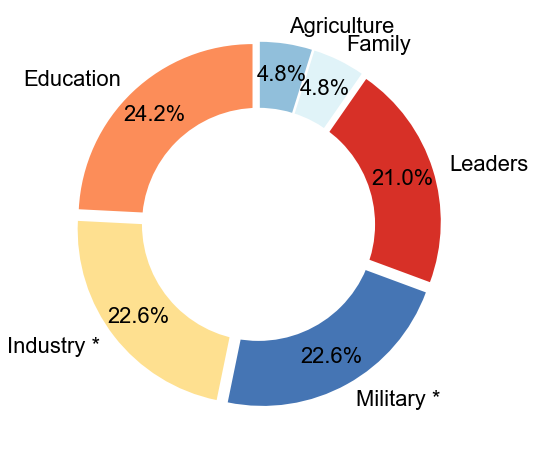

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)
topic_columns = list(topic_res.columns)
topic_columns.pop(topic_columns.index('dominant_topic'))
colors_gender = ['#fc8d59','#fee090','#4575b4','#d73027','#e0f3f8','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

### 3.2. Assessing significance of differences with permutation test

We separate between the subgroup we are interested in (canonized writers before canonization) and the rest.

In [30]:
indices_not_stars = [i for i in range(len(ori_df)) if i not in indices_before_stars]

We merge the leaders columns

In [31]:
topics_before_stars = np.column_stack([np.round(nmf_output[indices_before_stars], 2)[:,0], np.round(nmf_output[indices_before_stars], 2)[:,1] + np.round(nmf_output[indices_before_stars], 2)[:,3], np.round(nmf_output[indices_before_stars], 2)[:,2], np.round(nmf_output[indices_before_stars], 2)[:,4:]])

In [32]:
topics_not_stars = np.column_stack([np.round(nmf_output[indices_not_stars], 2)[:,0], np.round(nmf_output[indices_not_stars], 2)[:,1] + np.round(nmf_output[indices_not_stars], 2)[:,3], np.round(nmf_output[indices_not_stars], 2)[:,2], np.round(nmf_output[indices_not_stars], 2)[:,4:]])

In [21]:
# http://www2.stat.duke.edu/~ar182/rr/examples-gallery/PermutationTest.html

def run_permutation_test(pooled,sizeZ,sizeY,delta):
    np.random.shuffle(pooled)
    starZ = pooled[:sizeZ]
    starY = pooled[-sizeY:]
    return starZ.mean() - starY.mean()

In [20]:
# one hot encoding of dominant topic
def dominant_as_binary_array(a):
    b = np.zeros_like(a)
    b[np.arange(len(a)), a.argmax(1)] = 1
    return b

#dominant_as_binary_array(topics_before_stars)

In [36]:
np.random.seed(7)
reframed_topics = ['Education', 'Leaders', 'Family', 'Industry', 'Agriculture', 'Military']
for i, topic in enumerate(reframed_topics):
    print(f"TOPIC: {topic}")
    z = dominant_as_binary_array(topics_before_stars)[:,i]
    y = dominant_as_binary_array(topics_not_stars)[:,i]
    #z = (topics_before_stars)[:,i]
    #y = (topics_not_stars)[:,i]
    theta_hat = z.mean() - y.mean()
    print(f"theta_hat: {theta_hat}")
    pooled = np.hstack([z,y])
    delta = z.mean() - y.mean()
    numSamples = 1000
    estimates = np.array(list(map(lambda x: run_permutation_test(pooled,z.size,y.size,delta),range(numSamples))))
    diffCount = len(np.where(estimates <=delta)[0])
    hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
    print(f"hat_asl_perm: {hat_asl_perm}")
    print('-'*20)

TOPIC: Education
theta_hat: -0.021001579066095177
hat_asl_perm: 0.601
--------------------
TOPIC: Leaders
theta_hat: 0.0005865102639296405
hat_asl_perm: 0.40800000000000003
--------------------
TOPIC: Family
theta_hat: -0.03762688923979246
hat_asl_perm: 0.778
--------------------
TOPIC: Industry
theta_hat: 0.10272952853598014
hat_asl_perm: 0.006000000000000005
--------------------
TOPIC: Agriculture
theta_hat: -0.10825625986916311
hat_asl_perm: 0.984
--------------------
TOPIC: Military
theta_hat: 0.06356868937514099
hat_asl_perm: 0.06699999999999995
--------------------


## 4. Topic distribution for canonized writers after canonization

### 4.1. Counting the number of stories concerned

In [219]:
for author, year in author_by_year.items():
    print(f"{author} : {sum(ori_df[ori_df['year'] >= year]['no_space'].apply(lambda x: is_author_present(author, x)))}")

백남룡 : 3
리신현 : 0
김삼복 : 1
윤경찬 : 1
안동춘 : 6
탁숙본 : 5
백보흠 : 4
정기종 : 5
김수경 : 0
림봉철 : 1
리동구 : 1
박태수 : 0
전흥식 : 0
최영조 : 1
윤정길 : 0
진재환 : 1
조권일 : 0
허춘식 : 0
권정웅 : 4
김병훈 : 4
남대현 : 1
리종렬 : 2
박룡운 : 0
석윤기 : 0
최학수 : 3
현승걸 : 3


In [38]:
indices_after_stars = []
for author, year in author_by_year.items():
    author_present = ori_df['no_space'].apply(lambda x: is_author_present(author, x))
    after_famous = ori_df['year'] >= year
    indices_after_stars += [i for i, found in enumerate(list(author_present & after_famous)) if found]

In [39]:
len(indices_after_stars)

46

In [40]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry', 'Agriculture', 'Military']
topic_res = pd.DataFrame(np.round(nmf_output[indices_after_stars], 2), columns=topics)
topic_res['Leaders *'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]

### 4.2. Charting the topic distribution

In [41]:
topic_res['dominant_topic'].value_counts()

Leaders *      28
Education       6
Military        5
Industry        4
Agriculture     2
Family          1
Name: dominant_topic, dtype: int64

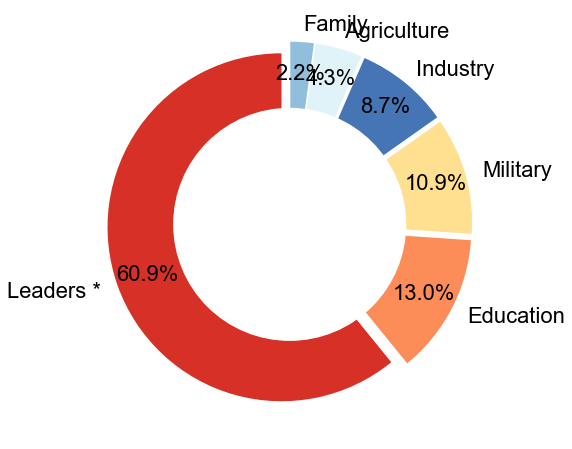

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)

colors_gender = ['#d73027','#fc8d59','#fee090','#4575b4','#e0f3f8','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [43]:
topics_after_stars = np.column_stack([np.round(nmf_output[indices_after_stars], 2)[:,0], np.round(nmf_output[indices_after_stars], 2)[:,1] + np.round(nmf_output[indices_after_stars], 2)[:,3], np.round(nmf_output[indices_after_stars], 2)[:,2], np.round(nmf_output[indices_after_stars], 2)[:,4:]])

In [46]:
indices_not_after_stars = [i for i in range(len(ori_df)) if i not in topics_after_stars]
topics_not_after_stars = np.column_stack([np.round(nmf_output[indices_not_after_stars], 2)[:,0], np.round(nmf_output[indices_not_after_stars], 2)[:,1] + np.round(nmf_output[indices_not_after_stars], 2)[:,3], np.round(nmf_output[indices_not_after_stars], 2)[:,2], np.round(nmf_output[indices_not_after_stars], 2)[:,4:]])

### 4.3. Assessing significance of differences with permutation test

In [54]:
np.random.seed(7)
reframed_topics = ['Education', 'Leaders', 'Family', 'Industry', 'Agriculture', 'Military']
for i, topic in enumerate(reframed_topics):
    print(f"TOPIC: {topic}")
    z = dominant_as_binary_array(topics_after_stars)[:,i]
    y = dominant_as_binary_array(topics_not_after_stars)[:,i]
    #z = (topics_after_stars)[:,i]
    #y = (topics_not_after_stars)[:,i]
    theta_hat = z.mean() - y.mean()
    print(f"theta_hat: {theta_hat}")
    pooled = np.hstack([z,y])
    delta = z.mean() - y.mean()
    numSamples = 1000
    estimates = np.array(list(map(lambda x: run_permutation_test(pooled,z.size,y.size,delta),range(numSamples))))
    diffCount = len(np.where(estimates <=delta)[0])
    hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
    print(f"hat_asl_perm: {hat_asl_perm}")
    print('-'*20)

TOPIC: Education
theta_hat: -0.13180532470183418
hat_asl_perm: 0.973
--------------------
TOPIC: Leaders
theta_hat: 0.3994401189747179
hat_asl_perm: 0.0
--------------------
TOPIC: Family
theta_hat: -0.06276791181873852
hat_asl_perm: 0.908
--------------------
TOPIC: Industry
theta_hat: -0.04047473245268715
hat_asl_perm: 0.7130000000000001
--------------------
TOPIC: Agriculture
theta_hat: -0.10876855334907998
hat_asl_perm: 0.971
--------------------
TOPIC: Military
theta_hat: -0.05562359665237805
hat_asl_perm: 0.759
--------------------


## 5. Topic distribution for the new guard (authors canonized after 1991) before canonization

In [56]:
indices_young_before_stars = []

for author, year in author_by_year.items():
    if year < 1991:
        continue
    author_present = ori_df['no_space'].apply(lambda x: is_author_present(author, x))
    before_famous = ori_df['year'] < year
    indices_young_before_stars += [i for i, found in enumerate(list(author_present & before_famous)) if found]

In [57]:
len(indices_young_before_stars)

44

In [58]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry', 'Agriculture *', 'Military *']
topic_res = pd.DataFrame(np.round(nmf_output[indices_young_before_stars], 2), columns=topics)
topic_res['Leaders'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]

### 5.1. Charting topic distribution for the new guard

In [60]:
topic_res['dominant_topic'].value_counts().reindex(topic_res.dominant_topic.unique(), fill_value=0)

Industry          8
Military *       12
Leaders           8
Agriculture *     3
Family            2
Education        11
Name: dominant_topic, dtype: int64

In [328]:
topic_columns

['Education', 'Family', 'Industry', 'Agriculture', 'Military', 'Leaders']

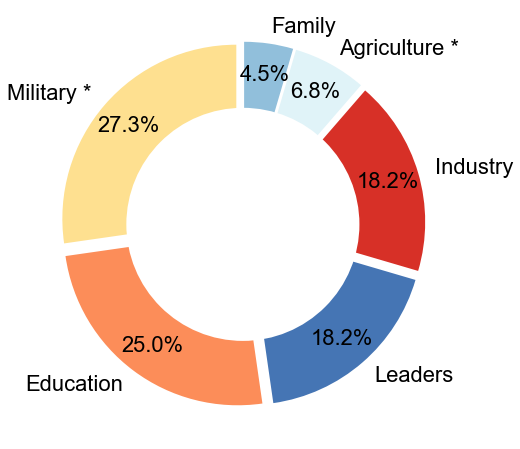

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)
topic_columns = list(topic_res.columns)
topic_columns.pop(topic_columns.index('dominant_topic'))
colors_gender = ['#fee090','#fc8d59','#4575b4','#d73027','#e0f3f8','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

### 5.2. Data for statistical significance study (used later)

In [62]:
topics_young_before_stars = np.column_stack([np.round(nmf_output[indices_young_before_stars], 2)[:,0], np.round(nmf_output[indices_young_before_stars], 2)[:,1] + np.round(nmf_output[indices_young_before_stars], 2)[:,3], np.round(nmf_output[indices_young_before_stars], 2)[:,2], np.round(nmf_output[indices_young_before_stars], 2)[:,4:]])

In [63]:
indices_not_young_before_stars = [i for i in range(len(ori_df)) if i not in indices_young_before_stars]
topics_not_young_before_stars = np.column_stack([np.round(nmf_output[indices_not_young_before_stars], 2)[:,0], np.round(nmf_output[indices_not_young_before_stars], 2)[:,1] + np.round(nmf_output[indices_not_young_before_stars], 2)[:,3], np.round(nmf_output[indices_not_young_before_stars], 2)[:,2], np.round(nmf_output[indices_not_young_before_stars], 2)[:,4:]])

## 6. Topic distribution for the old guard (authors canonized before 1991) before canonization

In [65]:
indices_old_before_stars = []

for author, year in author_by_year.items():
    if year >= 1991:
        continue
    author_present = ori_df['no_space'].apply(lambda x: is_author_present(author, x))
    before_famous = ori_df['year'] < year
    indices_old_before_stars += [i for i, found in enumerate(list(author_present & before_famous)) if found]

In [66]:
len(indices_old_before_stars)

18

In [67]:
import numpy as np
topics = ['Education', 'Leaders (1)', 'Family', 'Leaders (2)', 'Industry', 'Agriculture *', 'Military *']
topic_res = pd.DataFrame(np.round(nmf_output[indices_old_before_stars], 2), columns=topics)
topic_res['Leaders'] = topic_res['Leaders (1)'] + topic_res['Leaders (2)'] 
topic_res.drop([ 'Leaders (1)', 'Leaders (2)'], inplace=True, axis=1)
topic_res['dominant_topic'] = [topic_res.columns[max] for max in np.argmax(topic_res.values, axis=1)]

### 6.1. Plotting topic distribution for the old guard

In [68]:
topic_columns = list(topic_res.columns)
topic_columns.pop(topic_columns.index('dominant_topic'))
topic_res['dominant_topic'].value_counts(sort=False).reindex(topic_columns, fill_value=0.0000001)

Education        4.000000e+00
Family           1.000000e+00
Industry         6.000000e+00
Agriculture *    1.000000e-07
Military *       2.000000e+00
Leaders          5.000000e+00
Name: dominant_topic, dtype: float64

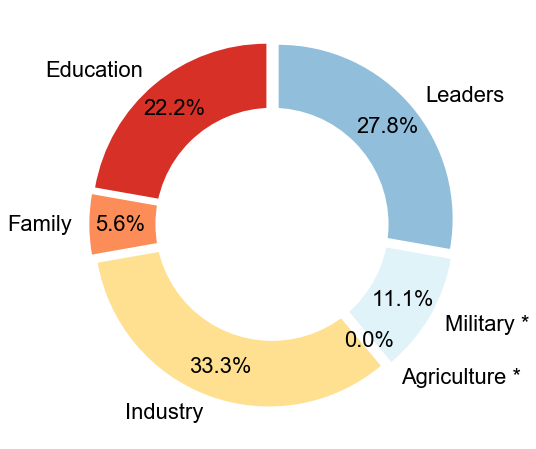

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rc('font', family=fm.FontProperties(fname='C:\\Windows\\Fonts\\arial.ttf').get_name(), size=22)

colors_gender = ['#d73027','#fc8d59','#fee090','#4575b4','#e0f3f8','#91bfdb']
ax=topic_res['dominant_topic'].value_counts().reindex(topic_columns, fill_value=0.0000001).plot.pie(colors=colors_gender, autopct='%1.1f%%', title='', figsize=(8,8), startangle=90, pctdistance=0.82, explode=len(topic_columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [71]:
topics_old_before_stars = np.column_stack([np.round(nmf_output[indices_old_before_stars], 2)[:,0], np.round(nmf_output[indices_old_before_stars], 2)[:,1] + np.round(nmf_output[indices_old_before_stars], 2)[:,3], np.round(nmf_output[indices_old_before_stars], 2)[:,2], np.round(nmf_output[indices_old_before_stars], 2)[:,4:]])

In [72]:
indices_not_old_before_stars = [i for i in range(len(ori_df)) if i not in indices_old_before_stars]
topics_not_old_before_stars = np.column_stack([np.round(nmf_output[indices_not_old_before_stars], 2)[:,0], np.round(nmf_output[indices_not_old_before_stars], 2)[:,1] + np.round(nmf_output[indices_not_old_before_stars], 2)[:,3], np.round(nmf_output[indices_not_old_before_stars], 2)[:,2], np.round(nmf_output[indices_not_old_before_stars], 2)[:,4:]])

### 6.2. Assessing significance of differences between the two groups

In [76]:
np.random.seed(7)
reframed_topics = ['Education', 'Leaders', 'Family', 'Industry', 'Agriculture', 'Military']
for i, topic in enumerate(reframed_topics):
    print(f"TOPIC: {topic}")
    z = dominant_as_binary_array(topics_young_before_stars)[:,i]
    y = dominant_as_binary_array(topics_old_before_stars)[:,i]
    #z = (topics_after_stars)[:,i]
    #y = (topics_not_after_stars)[:,i]
    theta_hat = z.mean() - y.mean()
    print(f"theta_hat: {theta_hat}")
    pooled = np.hstack([z,y])
    delta = z.mean() - y.mean()
    numSamples = 1000
    estimates = np.array(list(map(lambda x: run_permutation_test(pooled,z.size,y.size,delta),range(numSamples))))
    diffCount = len(np.where(estimates <=delta)[0])
    hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
    print(f"hat_asl_perm: {hat_asl_perm}")
    print('-'*20)

TOPIC: Education
theta_hat: 0.02777777777777779
hat_asl_perm: 0.28400000000000003
--------------------
TOPIC: Leaders
theta_hat: -0.09595959595959597
hat_asl_perm: 0.7050000000000001
--------------------
TOPIC: Family
theta_hat: -0.010101010101010097
hat_asl_perm: 0.346
--------------------
TOPIC: Industry
theta_hat: -0.1515151515151515
hat_asl_perm: 0.821
--------------------
TOPIC: Agriculture
theta_hat: 0.06818181818181818
hat_asl_perm: 0.0
--------------------
TOPIC: Military
theta_hat: 0.1616161616161616
hat_asl_perm: 0.03400000000000003
--------------------
